# k-NN movie reccomendation


| User\Film | Movie A | Movie B | Movie C | ... | Movie # |
|---------------------------------------------------------|
| **User A**| 3       | 4       | 0       | ... | 5       |
| **User B**| 0       | 3       | 2       | ... | 0       |
| **User C**| 4       | 1       | 3       | ... | 4       |
| **User D**| 5       | 3       | 2       | ... | 3       |
|  ...      | ...     | ...     | ...     | ... | ...     |
| **User #**| 2       | 1       | 1       | ... | 4       |

Task: For a new user find k similar users based on movie rating and recommend few new, previously unseen, movies to the new user. Use mean rating of k users to find which one to recommend. Use cosine similarity as distance function. User didnt't see a movie if he didn't rate the movie.  

In [154]:
# Import necessary libraries
import tensorflow as tf
import numpy as np

In [155]:
# Define paramaters
set_size = 1000  # Number of users in dataset
n_features = 300 # Number of movies in dataset
K = 3            # Number of similary users
n_movies = 6     # Number of movies to reccomend

In [156]:
# Generate dummy data
data = np.array(np.random.randint(0, 6, size=(set_size, n_features)), dtype=np.float32)
new_user = np.array(np.random.randint(0, 6, size=(1, n_features)), dtype=np.float32)

# Find the number of movies that user did not rate
not_rated = np.count_nonzero(new_user == 0)

# Case in which the new user rated all movies in our dataset
if not_rated == 0:
    print('Regenerate new user')
    
# Case in which we try to recommend more movies than user didn't see
if not_rated < n_movies:
    print('Regenerate new user')

# Print few examples
# print(data[:3])
# print(new_user)

In [157]:
# Input train vector
X1 = tf.placeholder(dtype=tf.float32, shape=[None, n_features], name="X1")

# Input test vector
X2 = tf.placeholder(dtype=tf.float32, shape=[1, n_features], name="X2")

In [158]:
# Cosine similarity
norm_X1 = tf.nn.l2_normalize(X1, axis=1)        
norm_X2 = tf.nn.l2_normalize(X2, axis=1)
cos_similarity = tf.reduce_sum(tf.matmul(norm_X1, tf.transpose(norm_X2)), axis=1)

In [159]:
with tf.Session() as sess:
    
    # Find all distances
    distances = sess.run(cos_similarity, feed_dict={X1: data, X2: new_user})
    # print(distances)
    
    # Find indices of k user with highest similarity
    _, user_indices = sess.run(tf.nn.top_k(distances, K))
    # print(user_indices)
    
    # Get users rating
    # print(data[user_indices])
    
    # New user ratings
    # print(new_user[0])
    
    # NOTICE:
    # There is a possibility that we can incorporate
    # user for e.g. movie A which he didn't see.
    movie_ratings = sess.run(tf.reduce_mean(data[user_indices], axis=0))
    # print(movie_ratings)
    
    # Positions where the new user doesn't have rating
    # NOTICE:
    # In random generating there is a possibility that 
    # the new user rated all movies in data set, if that
    # happens regenerate the new user.
    movie_indices = sess.run(tf.where(tf.equal(new_user[0], 0)))
    # print(movie_indices)
    
    # Pick only the avarege rating of movies that have been rated by
    # other users and haven't been rated by the new user and among
    # those movies pick n_movies for recommend to the new user
    _, top_rated_indices = sess.run(tf.nn.top_k(movie_ratings[movie_indices].reshape(-1), n_movies))
    # print(top_rated_indices)
    
    # Indices of the movies with the highest mean rating, which new user did not
    # see, from the k most similary users based on movie ratings
    print('Movie indices to reccomend: ', movie_indices[top_rated_indices].T)

Movie indices to reccomend:  [[ 27 157 274  29 167  52]]


# Locally weighted regression (LOWESS)

In [1]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
tf.reset_default_graph()

In [3]:
# Load data as numpy array
x, y = np.loadtxt('../../data/02_LinearRegression/polynomial.csv', delimiter=',', unpack=True)
m = x.shape[0]

In [4]:
x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
y = (y - np.mean(y)) / np.std(y)

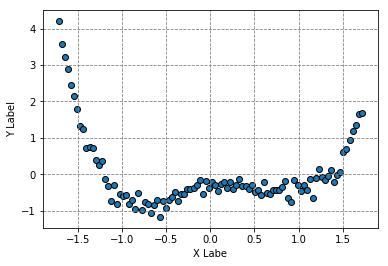

In [5]:
# Graphical preview
%matplotlib inline
fig, ax = plt.subplots()
ax.set_xlabel('X Labe')
ax.set_ylabel('Y Label')
ax.scatter(x, y, edgecolors='k', label='Data')
ax.grid(True, color='gray', linestyle='dashed')

In [6]:
X = tf.placeholder(tf.float32, name='X')
Y = tf.placeholder(tf.float32, name='Y')

In [8]:
w = tf.Variable(0.0, name='weights')
b = tf.Variable(0.0, name='bias')

In [9]:
point_x = -0.5
tau = 0.15 # 0.22

In [10]:
t_w = tf.exp(tf.div(-tf.pow(tf.subtract(X, point_x), 2), tf.multiply(tf.pow(tau, 2), 2)))

In [11]:
Y_predicted = tf.add(tf.multiply(X, w), b) 

In [12]:
cost = tf.reduce_mean(tf.multiply(tf.square(Y - Y_predicted), t_w), name='cost')

In [13]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(cost)

In [14]:
with tf.Session() as sess:
    
    # Initialize the necessary variables, in this case, w and b
    sess.run(tf.global_variables_initializer()) 

    # Train the model in 50 epochs
    for i in range(500):
        
        total_cost = 0
        
        # Session runs train_op and fetch values of loss
        for sample in range(m):
            
            # Session looks at all trainable variables that loss depends on and update them
            _, l = sess.run([optimizer, cost], feed_dict={X: x[sample], Y:y[sample]}) 
            
            total_cost += l
        
        # Print epoch and loss
        if i % 50 == 0:
            print('Epoch {0}: {1}'.format(i, total_cost / m))
 
    # Output the values of w and b
    w1, b1 = sess.run([w, b])
    print(sess.run(t_w, feed_dict={X: 1.4}))
    print('W: %f, b: %f' % (w1, b1))
    print('Cost: %f' % sess.run(cost, feed_dict={X: x, Y: y}))

Epoch 0: 0.0634478747775861
Epoch 50: 0.007736005756521843
Epoch 100: 0.004038000959155567
Epoch 150: 0.0037609087880117664
Epoch 200: 0.0037122827295769005
Epoch 250: 0.003680550229646384
Epoch 300: 0.0036512052056435814
Epoch 350: 0.00362311072266426
Epoch 400: 0.0035961129753376004
Epoch 450: 0.0035701532227510966
1.4452242e-35
W: 0.413292, b: -0.540822
Cost: 0.003539


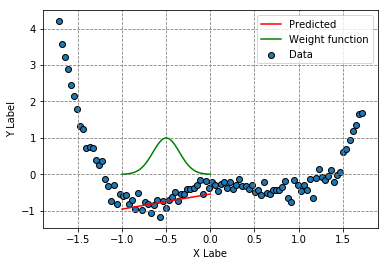

In [173]:
# Append hypothesis that we found on the plot
x1 = np.linspace(-1.0, 0.0, 50)
ax.plot(x1, x1 * w1 + b1, color='r', label='Predicted')
ax.plot(x1, np.exp(-(x1 - point_x) ** 2 / (2 * 0.15 ** 2)), color='g', label='Weight function')
ax.legend()
fig